# Ford GoBike dataset analysis
## by Andrés Ingelmo Poveda

## Preliminary Wrangling

This dataset includes informationabout individual rides made in a bike-sharing system covering the greater San Francisco area during the month of February 2019. Questions like "how long does the average trip take" or "how does suscription status impacts in the results" will be answered. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import requests

%matplotlib inline

In [2]:
url = "https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv"
file = "fordgobikedata.csv"

# Function to get the file from the cloud
def get_file(url, file):
    # Get the file from the cloud
    content = requests.get(url).text
    # Write the file into "fordgobikedata.csv"
    with open(file, "w", encoding="utf-8") as f:
        f.write(content)
        
##Run only the first time to get the file from the cloud!
#get_file(url, file) ##<-- Remove "#" to run 

# Load the csv file into a pandas dataframe
ford = pd.read_csv(file)

### What is the structure of your dataset?

In [3]:
ford.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [4]:
ford.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

### What is/are the feature(s) of interest in your dataset?

The main features of interest in the data are:
- `duration_sec`: the main feature of exploration.
- `start_time`and `end_time`: it can provide valuable data regarding the busiest hours.
- `start_station_id` and `end_station_id`: it can provide data regarding the busiest stations.
- `bike_id`: is there any bike that is more used than others?
- `user_type`: it can provide valuable data regarding different behaviours from customers and suscribers.
- `member_birth_year`: are young people using bikesharing more?
- `member_gender`: is gender determinant while bikesharing? is there a different behaviour?

The data needs some cleaning to convert the variables into its correct type. But first, a copy of the original dataframe will be done.

In [5]:
#Create a copy of the original
ford_clean = ford.copy()


#Convert to date/time
ford_clean["start_time"] = pd.to_datetime(ford_clean["start_time"])
ford_clean["end_time"] = pd.to_datetime(ford_clean["end_time"])

#Convert to strings as not calculations are required for the data below
to_clean = ["start_station_id", "end_station_id", "bike_id", "member_birth_year"]

for i in to_clean:
    ford_clean[i] = ford_clean[i].fillna(0).astype(int).astype(str)
    
#Drop Columns not necessary for the analysis
ford_clean.drop(labels=["start_station_latitude", "start_station_longitude", "end_station_latitude", "end_station_longitude"], axis=1, inplace=True);

In [6]:
ford_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             183412 non-null  int64         
 1   start_time               183412 non-null  datetime64[ns]
 2   end_time                 183412 non-null  datetime64[ns]
 3   start_station_id         183412 non-null  object        
 4   start_station_name       183215 non-null  object        
 5   end_station_id           183412 non-null  object        
 6   end_station_name         183215 non-null  object        
 7   bike_id                  183412 non-null  object        
 8   user_type                183412 non-null  object        
 9   member_birth_year        183412 non-null  object        
 10  member_gender            175147 non-null  object        
 11  bike_share_for_all_trip  183412 non-null  object        
dtypes: datetime64[ns

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

In [19]:
#Set color
base_color = sb.color_palette()[0]

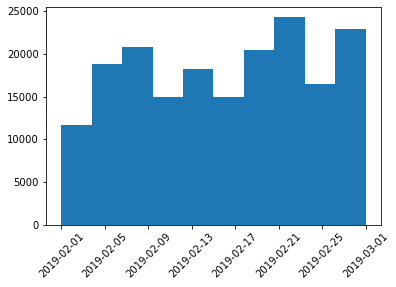

In [24]:
plt.hist(ford_clean["start_time"])
plt.xticks(rotation=45);

C:\Users\andrw\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\andrw\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\andrw\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


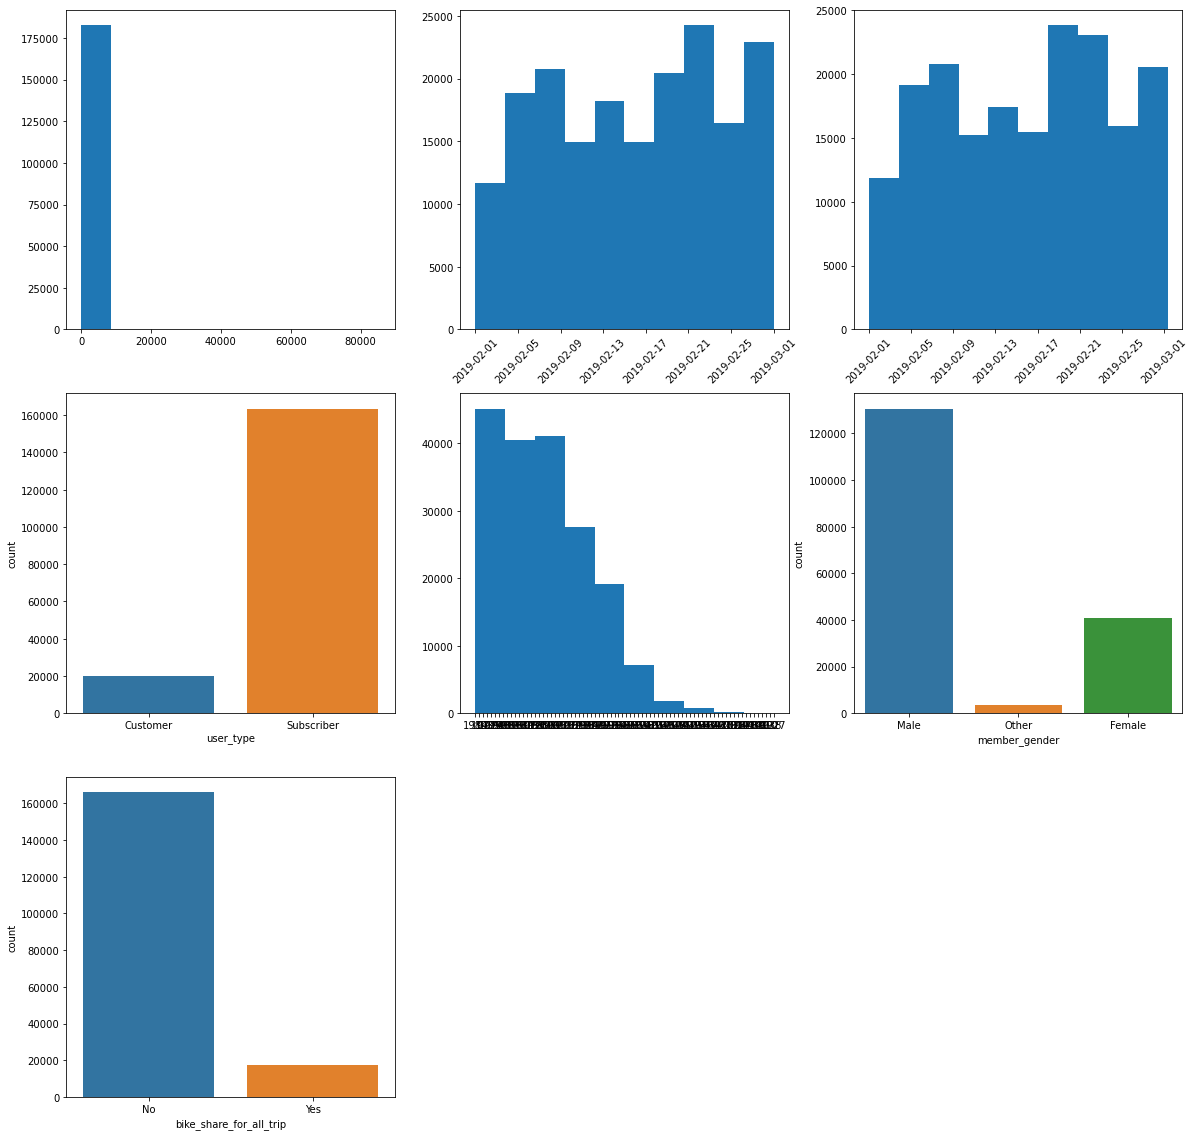

In [15]:
plt.figure(figsize=[20,20])

plt.subplot(3,3,1)
plt.hist(ford_clean["duration_sec"]);

plt.subplot(3,3,2)
plt.hist(ford_clean["start_time"])
plt.xticks(rotation=45);

plt.subplot(3,3,3)
plt.hist(ford_clean["end_time"])
plt.xticks(rotation=45);

plt.subplot(3,3,4)
sb.countplot(ford_clean["user_type"]);

plt.subplot(3,3,5)
plt.hist(ford_clean["member_birth_year"]);

plt.subplot(3,3,6)
sb.countplot(ford_clean["member_gender"]);

plt.subplot(3,3,7)
sb.countplot(ford_clean["bike_share_for_all_trip"]);


> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

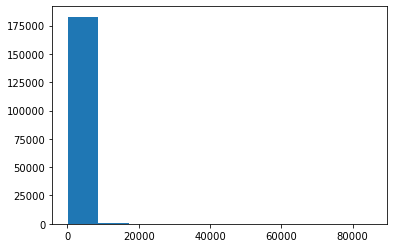

In [18]:
plt.hist(ford_clean["duration_sec"]);

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!